# Введение

У нас имеется файл с историческими данными о продажах игр, оценках пользователей и экспертов, а также жанрах и платформах. Нам необходимо выявить закономерности, которые определяют успешность игры. На основе полученных нами результатов наши коллеги смогут сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

# Загрузка данных. Ознакомление с ними.

In [1]:
# импорт всех библиотек, необходимых для работы
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from scipy.stats import ttest_ind

In [2]:
# зададим общий стиль графиков seaborn
sns.set(style="darkgrid", rc={'figure.figsize':(9, 7.5)}, font_scale=1.35)
# заблокируем всплывающие предупреждения
warnings.filterwarnings("ignore")

Зададим стиль для старых блоков, которые более не используются в работе, но интересны с точки зрения эволюции проекта и способны улучшить понимание контекста вопросов ревьюера.

In [3]:
%%html
<style>
    .old {
        background: #F5F5F5;
        padding: 2% 2%;
        color: black;
        border: 0.1rem solid;
        border-radius: 4px;
        border-color: darkgray;
    }
</style>

In [4]:
# чтение данных из фала
file_name = 'games.csv'
path_to_file = '/datasets/'

# путь до файла записывается по-разному при работе на сервере и локально
try:
    games_df = pd.read_csv(path_to_file + file_name)
except FileNotFoundError:
    games_df = pd.read_csv('.' + path_to_file + file_name)

In [5]:
# вывод первых 10 строк
games_df.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [6]:
# вывод основной информации по датасету
games_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 5.6 MB


- датасет содержит 16715 строк и 11 столбцов;
- пропуски встречаются в 6 колонках;
- данные автоматически были приведены либо к типу `float64`, либо `object`, что не совсем оптимально для некоторых столбцов;
- датасет использует 5.6 Мб памяти.

In [7]:
# посчитаем число пропусков в каждой колонке
games_df.isna().sum().sort_values()

Platform              0
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Name                  2
Genre                 2
Year_of_Release     269
User_Score         6701
Rating             6766
Critic_Score       8578
dtype: int64

Больше всего пропусков в колонке "Critic_score", также много пропусков в колонках "User_score" и "Rating".

In [8]:
# Посчитаем число полностью продублированных строк
print("Число строк дубликатов:", games_df.duplicated().sum())

Число строк дубликатов: 0


In [9]:
# выведем основную описательную статистику для числовых колонок
games_df.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


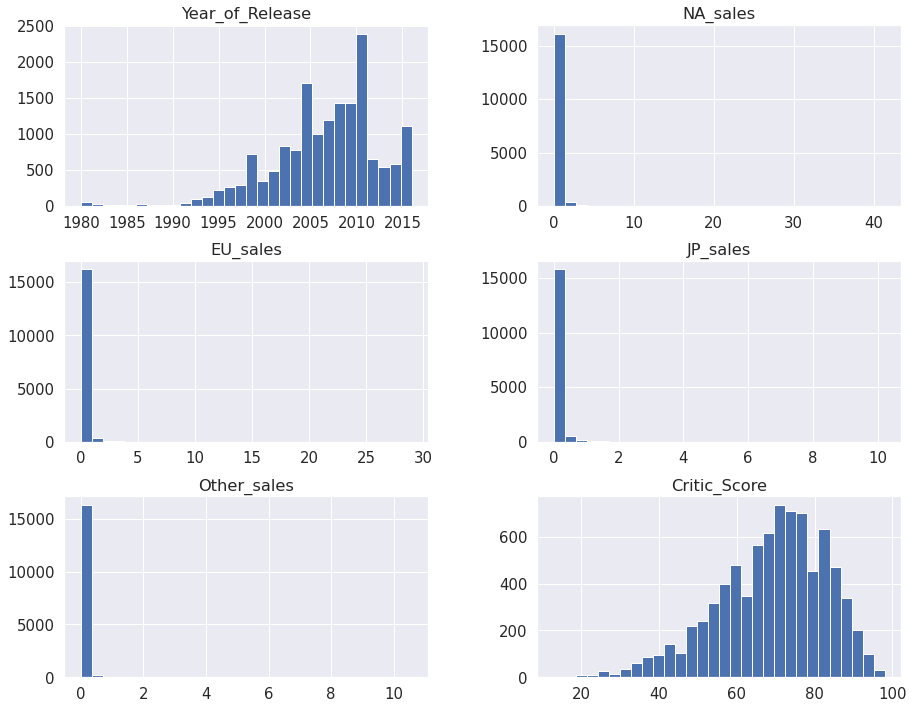

In [10]:
# строим гистограммы для числовых данных
games_df.hist(bins=30, figsize=(15,12));

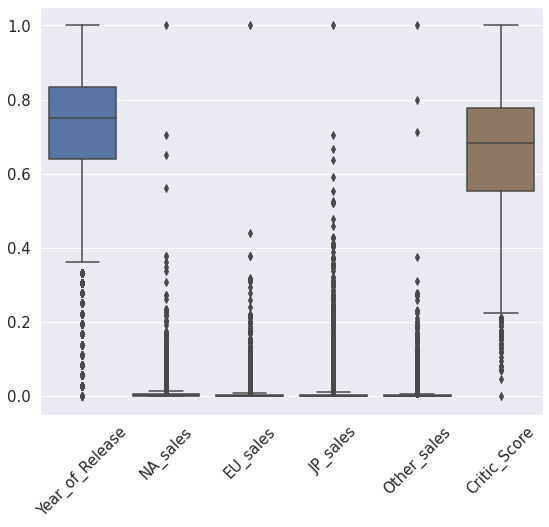

In [11]:
# для отображения построений boxplot от разных колонок на одном графике, для которых значения могут отличаться в разы,
# нормируем значения на диапазон [0, 1]
numeric_df = games_df.select_dtypes(include=np.float64)  # выбираем только числовые колонки
normalized_df = (numeric_df - numeric_df.min()) / (numeric_df.max() - numeric_df.min())  # проводим нормировку 
ax = sns.boxplot(data=normalized_df);
plt.setp(ax.get_xticklabels(), rotation=45);

- в большинстве колонок присутсвует большое количество выбросов
- из-за выбросов распределение многих колонок выглядит как один огромный пик около нулевого значения, в связи с чем из таких построений невозможно судить о характере распределений
- распределение значений в колонке "Critic_score" близко к нормальному со скосом влево
- для колонки "Year_of release" наблюдаются аномально высокие значения вблизи 2015, 2010, 2005 и 1999

Для более детального и корректного анализа данных необходимо провести предобработку.

# Предобработка данных

## Техническая и семантическая очистка

- устранение пропусков
- устранение дублей (явных и неявных)
- устранение противоречий
- устранение смысловых ошибок

### Переименование столбцов

In [12]:
# приведем все названия столбцов к питоновскому стилю
# в данном случае нужно только привести всё к нижнему регистру
# games_df.rename(str.lower, axis='columns', inplace=True)

games_df.columns = games_df.columns.str.lower()
games_df.columns # проверяем что всё сработало

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [13]:
# для будущего сравнения заведем переменные с общим числом строк и непустых данных для каждой колонки до чистки данных
unfiltered_rows_num = games_df.shape[0]
unfiltered_notempty_rows_nums = games_df.notna().sum()
unfiltered_notempty_rows_nums

name               16713
platform           16715
year_of_release    16446
genre              16713
na_sales           16715
eu_sales           16715
jp_sales           16715
other_sales        16715
critic_score        8137
user_score         10014
rating              9949
dtype: int64

### `name`

В колонке содержатся названия игр.

In [14]:
# ранее мы посчитали, что в данной колонке содержатся два пропуска, выведем эти строки
games_df[games_df.name.isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Видно, что в данных строках помимо названия игры также отсутвуют значения еще в 4х колоках. Учитывая, что строк всего две, их удаление едва ли может значительно изменить общую статистику.

In [15]:
# удаляем строки с пропусками в колонке
games_df.dropna(subset=['name'], inplace=True)

In [16]:
# посмотрим число строк, в которых дублируются названия
games_df[games_df.name.duplicated()].sort_values('name')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
3862,Frozen: Olaf's Quest,DS,2013.0,Platform,0.21,0.26,0.00,0.04,NaN,NaN,NaN
9507,007: Quantum of Solace,DS,2008.0,Action,0.11,0.01,0.00,0.01,65.0,tbd,T
4475,007: Quantum of Solace,PS2,2008.0,Action,0.17,0.00,0.00,0.26,NaN,NaN,NaN
1785,007: Quantum of Solace,PS3,2008.0,Action,0.43,0.51,0.02,0.19,65.0,6.6,T
3120,007: Quantum of Solace,Wii,2008.0,Action,0.29,0.28,0.01,0.07,54.0,7.5,T
...,...,...,...,...,...,...,...,...,...,...,...
12648,pro evolution soccer 2011,PC,2010.0,Sports,0.00,0.05,0.00,0.01,79.0,NaN,NaN
3304,pro evolution soccer 2011,X360,2010.0,Sports,0.09,0.44,0.00,0.07,79.0,5.9,E
4664,pro evolution soccer 2011,PS2,2010.0,Sports,0.04,0.21,0.05,0.11,NaN,6.7,E
2583,pro evolution soccer 2011,PSP,2010.0,Sports,0.05,0.30,0.29,0.16,74.0,5.8,E


Всего 5154 строки. Дублирование связано с тем, что многие игры выходили на разных платформах, и информация, соответвующая одной платформе, выводится в отдельной строке.

### `platform`

Краткое название платформы, на которой была выпущена игра.

In [17]:
# посмотрим уникальные названия платформ
platforms = games_df.platform.unique()
# отсортируем в алфавитном порядке
platforms.sort()

print("Общее число игровых платформ:", platforms.size)
print("Названия платформ: ", end='')
print(*platforms, sep=', ')

Общее число игровых платформ: 31
Названия платформ: 2600, 3DO, 3DS, DC, DS, GB, GBA, GC, GEN, GG, N64, NES, NG, PC, PCFX, PS, PS2, PS3, PS4, PSP, PSV, SAT, SCD, SNES, TG16, WS, Wii, WiiU, X360, XB, XOne


В колонке нет пропущенных значений (было выявлено на первом шаге), в ней указываются аббревиатуры игровых платформ. Соответственно, каждую платформу можно воспринимать как отдельную категорию.

In [18]:
# приведем тип данных в колонке к categorical
games_df.platform = games_df.platform.astype('category')

### `year_of_release`

Год выхода игры.

In [19]:
# выведем первые 10 строк с отсутствующими значениями в колонке
games_df[games_df.year_of_release.isna()].sort_values('name', ascending=False).head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
8884,eJay Clubworld,PS2,NaN,Misc,0.07,0.06,0.00,0.02,69.0,8.6,E
11433,Zero: Tsukihami no Kamen,Wii,NaN,Action,0.00,0.00,0.08,0.00,NaN,NaN,NaN
15557,Yu-Gi-Oh! 5D's Wheelie Breakers (JP sales),Wii,NaN,Racing,0.00,0.00,0.02,0.00,NaN,NaN,NaN
7332,Yu Yu Hakusho: Dark Tournament,PS2,NaN,Fighting,0.10,0.08,0.00,0.03,56.0,8.5,T
11957,Yoostar on MTV,X360,NaN,Misc,0.07,0.00,0.00,0.01,49.0,tbd,T
2169,Yakuza 4,PS3,NaN,Action,0.15,0.13,0.63,0.05,78.0,8,M
15704,Writing and Speaking Beautiful Japanese DS,DS,NaN,Misc,0.00,0.00,0.02,0.00,NaN,NaN,NaN
14685,World of Tanks,X360,NaN,Shooter,0.00,0.03,0.00,0.00,NaN,5.2,NaN
15816,Without Warning,XB,NaN,Shooter,0.01,0.00,0.00,0.00,45.0,2,M


Можно предположить, что в случаях некоторых игр, которые были выпущены на нескольких платформах, значения в колонке "year_of_release" отсутствуют не во всех записях.

In [20]:
# проверим на примере World of Tanks
games_df.query('name == "World of Tanks"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
6077,World of Tanks,PC,2011.0,Shooter,0.0,0.23,0.0,0.05,80.0,3.7,T
14685,World of Tanks,X360,NaN,Shooter,0.0,0.03,0.0,0.00,NaN,5.2,NaN


Таким образом, в этих случаях пропуски можно заполнить средней/медианной датой выхода игры на других платформах, для которых информация о годе выхода предоставлена. Конечно, это не означает, что на разных платформах игры выходят в один и тот же год, но как правило различие не велико.

In [21]:
# группируем строки по называнию игры
median_year_of_release = games_df.groupby('name').year_of_release

# заполняем значения NaN в случае игр, для которых определены годы выхода на других платформах 
games_df['year_of_release'] = median_year_of_release.transform(lambda x: x.fillna(round(x.median(),0)))

print('Оставшееся кол-во значений NaN в колонке:', games_df.year_of_release.isna().sum())

Оставшееся кол-во значений NaN в колонке: 146


Поскольку оставшихся пропусков достаточно мало, удалим их из рассмотрения. Для данной колонки логичнее всего было бы использовать тип datetime, однако тогда в каждой строке будет запись вида 'yyyy-01-01'. Поэтому приведем к типу `int`.

In [23]:
games_df = games_df.dropna(subset=['year_of_release'])
games_df.year_of_release = games_df.year_of_release.astype('int')

### `genre`

Жанр игры.

In [24]:
# посмотрим уникальные значения в колонке
games_df.genre.unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

Все названия "нормальные", нет неявных повторений и т.п. Ранее мы получили, что в данной колонке имеется два пропуска. Однако мы от них избавились при обработке колонки `name`. Остается только перевести тип данных колонки в categorical.

In [25]:
games_df.genre = games_df.genre.astype('category')

### `na_sales`, `eu_sales`, `jp_sales`, `other_sales`

- NA_sales - продажи в Северной Америке. 
- EU_sales - продажи в Европе. 
- JP_sales - продажи в Японии. 
- Other_sales - продажи в других странах. 

Все значения указаны в миллионах копий.

Пропущенных значений в данных колонках нет, однако для них наблюдались большие выбросы.

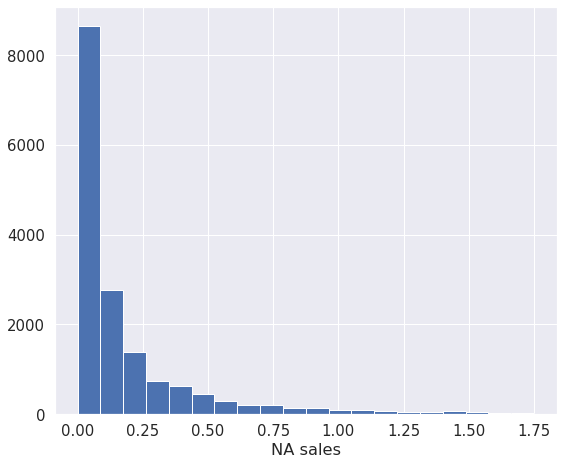

In [26]:
# построим гистограмму для колонки NA_sales в диапазоне от 0 до 1.75 млн. копий
top_limit = 1.75  # приблизительно в 7 раз больше чем среднее значение для колонки, которое получали в первом пункте
games_df.na_sales.hist(bins=20, range=(0, top_limit))
plt.xlabel('NA sales');

In [27]:
# гистограмма выглядит гораздо лучше, чем прежде
# посмотрим сколько всего записей присутсвует в датасете со значением na_sales > 1.75
games_above_top_limit_na = games_df.query("na_sales > @top_limit")
phrase = lambda x, y: f'Количество игр, проданных в {x} тиражом более {y} млн. копий:'
print(phrase('Северной Америке', top_limit), games_above_top_limit_na.shape[0])

Количество игр, проданных в Северной Америке тиражом более 1.75 млн. копий: 400


In [28]:
# значений относительно немного, удалим из рассмотрения выбросы
games_df.drop(games_above_top_limit_na.index, inplace=True)

In [29]:
# поскольку значения варьируются от 0 до 2 и не требуют высокой точности, 
# тип данных можно привести к float32
games_df.na_sales = games_df.na_sales.astype('float32')

Количество игр, проданных в Европе тиражом более 0.79 млн. копий: 348


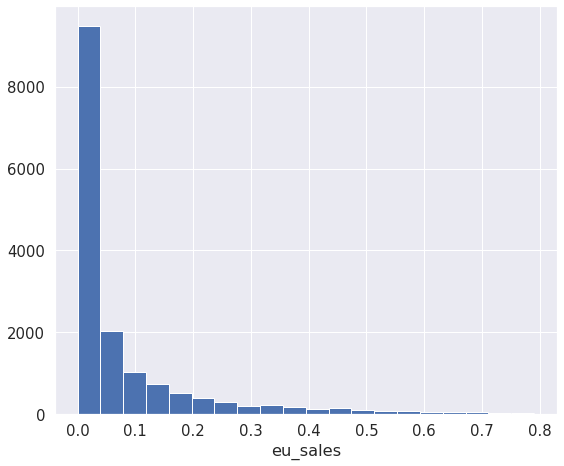

Количество игр, проданных в Японии тиражом более 0.46 млн. копий: 479


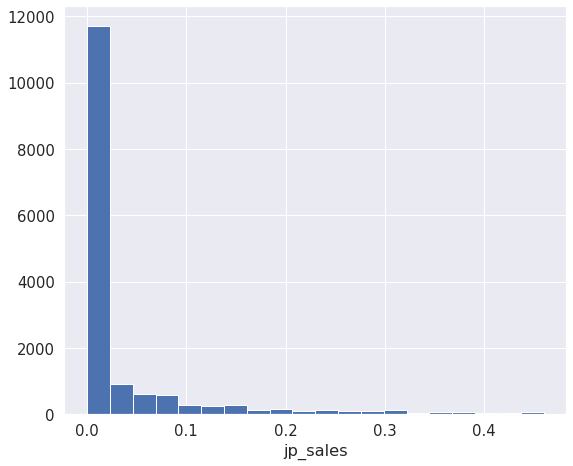

Количество игр, проданных в других странах тиражом более 0.26 млн. копий: 304


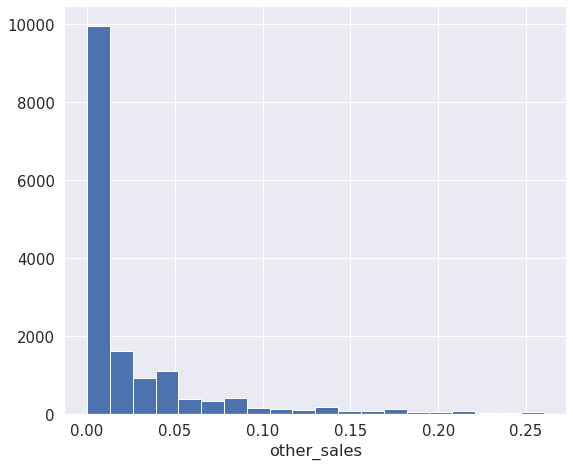

In [30]:
# рассмотрим теперь ситуацию для остальных колонок
phrases = iter(['Европе', 'Японии', 'других странах'])
regions = ['eu_sales', 'jp_sales', 'other_sales']
above_mean = 7.5

for region in regions:
    top_limit = round(games_df[region].mean() * above_mean, 2)
    
    games_above_top_limit = games_df[games_df[region] > top_limit]
    print(phrase(next(phrases), top_limit), games_above_top_limit.shape[0])
    
    games_df[region].hist(bins=20, range=(0, top_limit))
    plt.xlabel(region);
    plt.show()

In [31]:
# все гистограммы выглядят гораздо лучше
# удалим все соответствующие записи с выбросами
# также приведем тип данных к float32

for region in regions:
    top_limit = round(games_df[region].mean() * above_mean, 2)
    games_df.drop(games_df[games_df[region] > top_limit].index, inplace=True)
    games_df[region] = games_df[region].astype('float32')

In [32]:
print(f"После чистки осталось записей: {games_df.shape[0]}")

После чистки осталось записей: 15121


In [33]:
# доля удаленных непропущенных данных для каждого столбца
round(100 - games_df.notna().sum() / unfiltered_notempty_rows_nums * 100, 2)

name                9.53
platform            9.54
year_of_release     8.06
genre               9.53
na_sales            9.54
eu_sales            9.54
jp_sales            9.54
other_sales         9.54
critic_score       11.04
user_score          9.59
rating              9.68
dtype: float64

### `critic_score`, `user_score`, `rating`

- critic_score - оценка критиков (от 0 до 100)
- user_score - оценка пользователей (от 0 до 10)
- rating - рейтинг от организации ESRB

Пропуски в колонках critic_score и user_score возможно связаны с тем, что для расчета оценки требуется какое-то определенное минимальное количество пользователей, поставивших игре оценку.

Достоверно заполнить пропуски в колонках с рейтингом не представляется возможным. Заполнение медианным или средним значением по колонке сильно исказит распределение и может привести к абсолютно неправильным выводам. Можно было бы заполнить пропуски средними/медианными значениями для случаев, когда для одной и той же игры есть рейтинг для одних платформ, но нет для других, но часто случается, что оценка в зависимости от платформы может отличаться очень сильно, из-за чего данный метод также неприемлем.  

In [34]:
# в колонке critic_score оставим значения как есть, только изменим тип данных на float32
games_df.critic_score = games_df.critic_score.astype('float32')

# заглянем в колонку user_score и попытаемся понять, почему для нее тип данных автоматически определился как object
# для этого выведем все уникальные строковые значения и посчитаем их количество
games_df[(games_df.user_score.notna()) & (games_df.user_score.str.isalpha())].user_score.value_counts()

tbd    2376
Name: user_score, dtype: int64

2401 запись со значением 'tbd'. Один из вариантов расшифровки аббревиатуры - "to be determined". Т.е. значения также неизвестны, как и в случае пропусков. Для того, чтобы можно было работать с числовыми рейтингами, которые имеются в колонке, переопределим tbd как NaN и изменим тип данных колонки на float32.

In [35]:
games_df.loc[games_df['user_score'] == 'tbd', 'user_score'] = np.nan
games_df.user_score = games_df.user_score.astype('float32')

In [36]:
# посмотрим уникальные значения рейтинга ESRB
games_df.rating.unique()

array(['E', nan, 'T', 'M', 'E10+', 'AO', 'EC', 'RP', 'K-A'], dtype=object)

Описание рейтинга ESRB:
- EC (Early childhood) — для детей младшего возраста, от 3 лет
- E (Everyone) — для всех. Первоначально "K-A" (Kids to Adults)
- E10+ (Everyone 10 and older) — для всех от 10 лет и старше
- T (Teen) — подросткам, от 13 лет
- M (Mature) — для взрослых, от 17 лет
- AO (Adults Only 18+) — только для взрослых, от 18 лет
- RP (Rating Pending) — ожидает присвоение рейтинга

Как видно, рейтинг "K-A" устарел.

In [37]:
print("Число записей с рейтингом K-A:", games_df.query('rating == "K-A"').rating.count())

Число записей с рейтингом K-A: 1


In [38]:
# всего одна запись, заменим рейтинг в ней на E
games_df.loc[games_df['rating'] == 'K-A', 'rating'] = 'E'

In [39]:
print("Число записей с рейтингом RP:", games_df.query('rating == "RP"').shape[0])

Число записей с рейтингом RP: 2


Рейтинг "RP" по сути относится к записям "без рейтинга". Заменим рейтинг "RP" и все пропущенные значения на "n/a" - not available. 

In [40]:
games_df.loc[(games_df.rating.isna()) | (games_df.rating == "RP"), 'rating'] = "n/a"

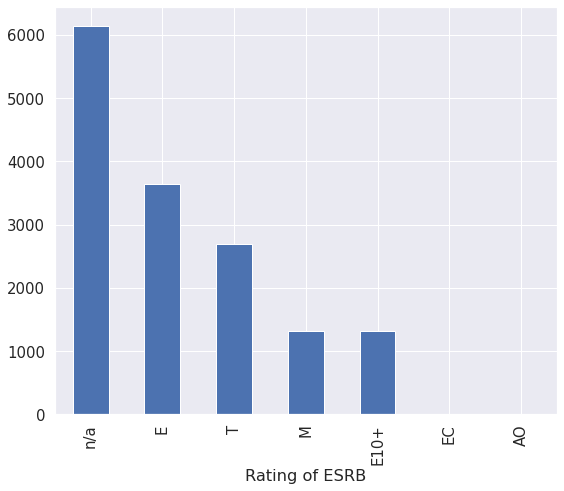

In [41]:
# построим гистограмму для колонки rating
games_df.rating.value_counts().plot(kind='bar')
plt.xlabel('Rating of ESRB');

In [42]:
# видно что значения в категориях EC и AO крайне малы и статистически мало значимы
for rating in ['EC', 'AO']:
    print(f"Число записей с рейтингом {rating}:", games_df.query('rating == @rating').shape[0])

Число записей с рейтингом EC: 8
Число записей с рейтингом AO: 1


In [43]:
# запишем EC как E а AO как M, поскольку они более всего подходят по смыслу
games_df.loc[games_df['rating'] == 'EC', 'rating'] = 'E'
games_df.loc[games_df['rating'] == 'AO', 'rating'] = 'M'

In [44]:
# сделаем тип данных в колонке категориальным
games_df.rating = games_df.rating.astype('category')

## Обогащение данных



In [45]:
# добавим колонку со значением продаж игры для определенной платформы во всех регионах
games_df['total_sales'] = games_df.iloc[:, 4:8].sum(axis=1)

In [47]:
# итоговый датафрейм
games_df.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
553,The Legend of Zelda: A Link to the Past,GBA,2002,Action,1.75,0.52,0.33,0.10,95.0,9.1,E,2.70
565,Mario vs. Donkey Kong: Mini-Land Mayhem!,DS,2010,Puzzle,1.63,0.51,0.35,0.18,79.0,7.7,E,2.67
601,Sonic Adventure 2 Battle,GC,2001,Platform,1.70,0.59,0.21,0.07,73.0,8.3,E,2.57
613,Perfect Dark,N64,2000,Action,1.55,0.75,0.16,0.06,NaN,NaN,n/a,2.52
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.00,0.20,71.0,NaN,E,2.42
660,Guitar Hero,PS2,2005,Misc,1.67,0.61,0.03,0.07,91.0,8.7,T,2.38
664,Dead Island,X360,2011,Action,1.48,0.69,0.00,0.20,71.0,6.9,M,2.37
669,Zumba Fitness,X360,2010,Sports,1.74,0.45,0.00,0.18,42.0,5.5,E,2.37
673,Donkey Kong Land II,GB,1996,Platform,1.39,0.48,0.40,0.08,NaN,NaN,n/a,2.35
675,Kinect: Disneyland Adventures,X360,2011,Misc,1.73,0.43,0.02,0.17,73.0,2.9,E10+,2.35


In [48]:
games_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15121 entries, 553 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             15121 non-null  object  
 1   platform         15121 non-null  category
 2   year_of_release  15121 non-null  int64   
 3   genre            15121 non-null  category
 4   na_sales         15121 non-null  float32 
 5   eu_sales         15121 non-null  float32 
 6   jp_sales         15121 non-null  float32 
 7   other_sales      15121 non-null  float32 
 8   critic_score     7239 non-null   float32 
 9   user_score       6678 non-null   float32 
 10  rating           15121 non-null  category
 11  total_sales      15121 non-null  float32 
dtypes: category(3), float32(7), int64(1), object(1)
memory usage: 1.9 MB


Итоговый датафрейм содержит 15121 строку, в исходном было 16715. Теперь вместо `float64` используется `float32`, также для некоторых колонок добавлен категориальный тип данных. Удалось сократить потребление памяти до 1.9 Мб.

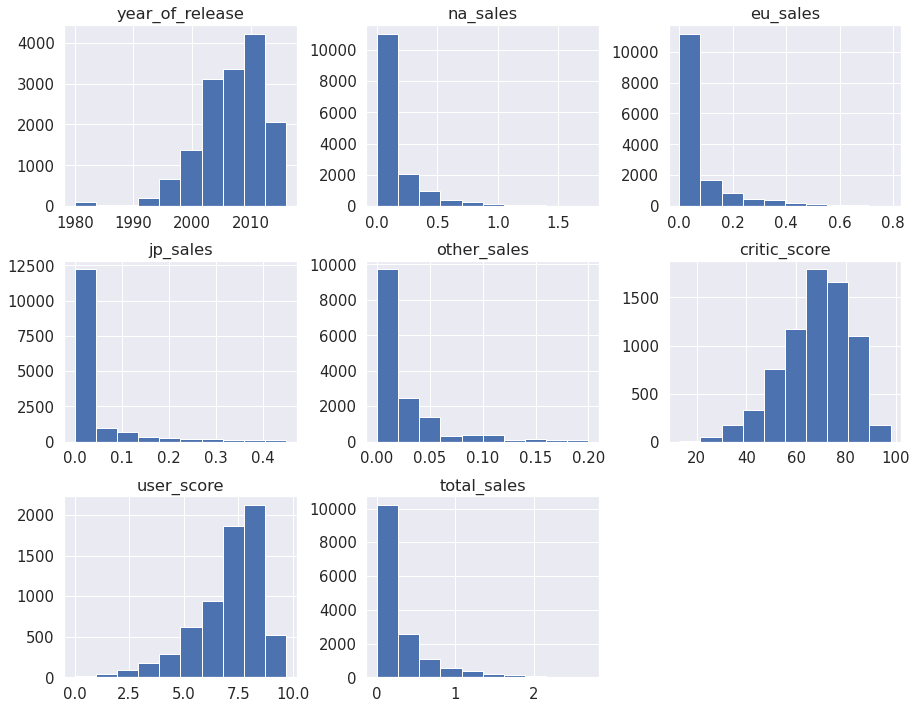

In [49]:
# построим гистограммы для колонок с числовыми типами данных
games_df.hist(figsize=(15, 12));

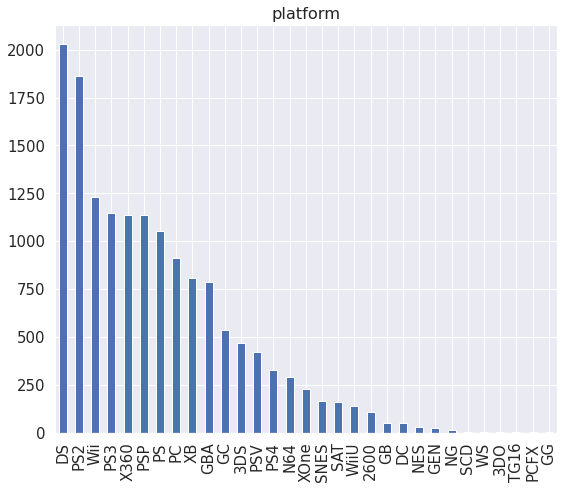

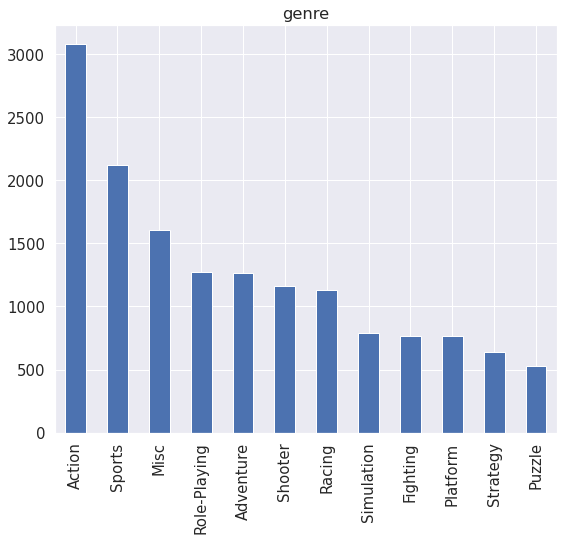

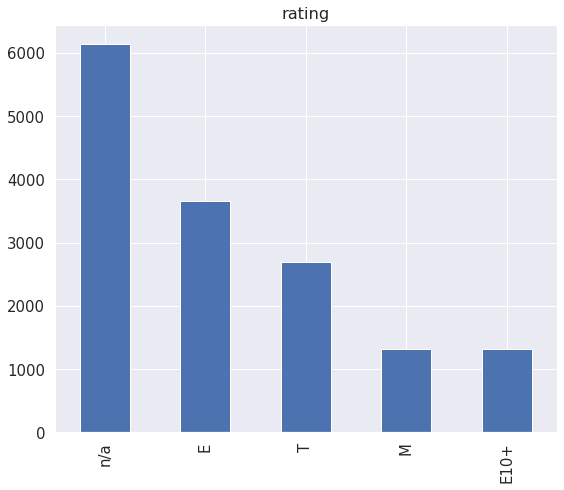

In [50]:
# построим гистограммы для колонок с категориальными типами данных
categorical_df = games_df.select_dtypes(include='category')
for column in categorical_df.columns:
    categorical_df[column].value_counts().plot(kind='bar', title=column)
    plt.show()

# Исследовательский анализ данных

## Зависимость количества выпускаемых игр от года

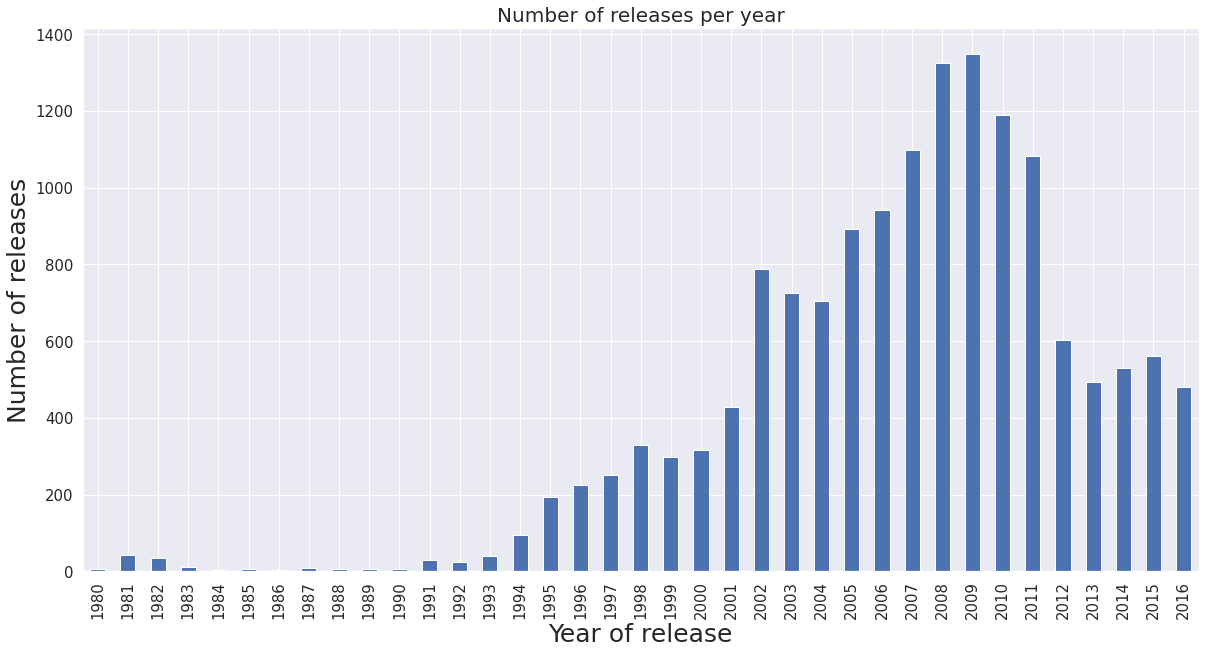

In [51]:
# построим гистограмму, отображающую число выпущенных игр за год
games_by_year = games_df.year_of_release.value_counts().sort_index()
games_by_year.index = games_by_year.index.astype('int')

games_by_year.plot(kind='bar')
plt.gcf().set_size_inches(20, 10)
plt.title('Number of releases per year', fontdict={'size': 20})
plt.xlabel('Year of release', fontsize=25)
plt.ylabel('Number of releases', fontsize=25);

- быстрый рост выпущенных за год игр начал происходить с 1994 года;
- пик выпущенных за год игр был достигнут в 2009 году, после чего начался спад;
- начиная с 2012 года количество выпускаемых в год игр изменяется незначительно;

## Зависимость продаж от года релиза и платформы

In [52]:
# построим общее число проданных копий для игр выпущенных в определнном году в зависимости от платформы
# для начала получим список из 15 платформ с самыми большими продажами за всё время 
platforms = games_df.groupby('platform').total_sales.sum().sort_values(ascending=False)[:15].index


print('Топ-15 платформ по продажам:', end=' ') 
print(*platforms.sort_values(), sep=', ')

Топ-15 платформ по продажам: 3DS, DS, GBA, GC, N64, PC, PS, PS2, PS3, PS4, PSP, Wii, X360, XB, XOne


In [53]:
# строим сводную таблицу
sub_games_df = games_df.query('platform in @platforms')
sales_by_platform = sub_games_df.pivot_table(index='year_of_release', 
                                             columns='platform', 
                                             values='total_sales', 
                                             aggfunc='sum',
                                             observed=True)  # исключаем из рассмотрения неиспользуемые категории
sales_by_platform.loc[2000, '3DS'] = np.nan
sales_by_platform.loc[1985, 'DS'] = np.nan
sales_by_platform

platform,3DS,DS,GBA,GC,N64,PC,PS,PS2,PS3,PS4,PSP,Wii,X360,XB,XOne
year_of_release,,,,,,,,,,,,,,,
1985,NaN,NaN,NaN,NaN,NaN,0.040000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988,NaN,NaN,NaN,NaN,NaN,0.030000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1992,NaN,NaN,NaN,NaN,NaN,0.890000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994,NaN,NaN,NaN,NaN,NaN,1.970000,3.980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995,NaN,NaN,NaN,NaN,NaN,0.020000,21.260000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,NaN,NaN,NaN,NaN,6.740000,1.030000,46.980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,NaN,NaN,NaN,NaN,19.629999,0.020000,64.540001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,NaN,NaN,NaN,NaN,28.129999,1.180000,89.309998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999,NaN,NaN,NaN,NaN,31.010000,1.730000,76.300003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


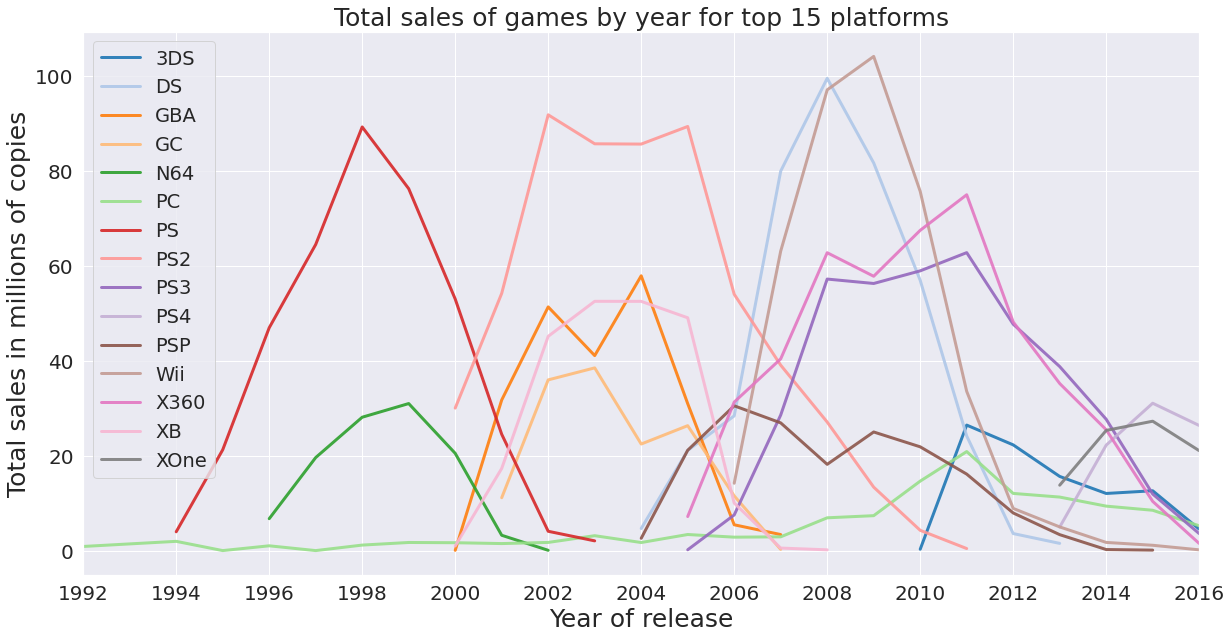

In [54]:
# берем цвета из встроенного набора tab20
palette = iter(plt.get_cmap('tab20').colors)

# для каждой платформы строим линию на графике
for column in sales_by_platform.columns:
    plt.plot(sales_by_platform[column], alpha=0.9, label=column, linewidth=3, color=next(palette))

# добавляем легенду и заголовок
plt.legend(loc='upper left', fontsize='large')
plt.title("Total sales of games by year for top 15 platforms", fontdict={'size': 25})

# добавляем подписи к осям и изменяем размер подписей
plt.xlabel('Year of release', fontdict={'size': 25})
plt.ylabel('Total sales in millions of copies', fontdict={'size': 25})
plt.xticks(ticks=np.linspace(1980, 2016, 19), fontsize=20)
plt.yticks(fontsize=20)

# задаем диапазон оси x
plt.xlim([1992, 2016])

# задаем размер графика
plt.gcf().set_size_inches(20, 10)
plt.show()

Если рассматривать продажи в зависимости от платформ, то видны следующие закономерности:
- "период жизни" платформы составляет около 7 лет, за это время происходит резкий рост продаж игр для платформы и такой же резкий спад;
- после выхода нового поколения консолей (например PS2 после PS или X360 после XB) продажи игр на консоли прошлого поколения спадают практически до нуля за 2-3 года;
- последний период (относительно 2016 года) начался в 2013 с выходом XOne и PS4;

In [55]:
print(f'"Время жизни" различных платформ из топ-15 (в годах):')
all_data = []  # сюда будем добавлять все посчитанные данные

for platform in platforms.sort_values():
    # убираем из рассмотрения все строки с NaN для колонки
    platform_sales_by_year = sales_by_platform[sales_by_platform[platform].notna()][platform]
    lifetime = platform_sales_by_year.index[-1] - platform_sales_by_year.index[0]
    
    all_data.append(lifetime)
    
    # печатаем результат
    print(f"{platform:>10}:", lifetime)
    
print("\nСреднее время жизни платформ из топ-15:", np.mean(all_data))
print("Медианное время жизни платформ из топ-15:", np.median(all_data))

"Время жизни" различных платформ из топ-15 (в годах):
       3DS: 6
        DS: 9
       GBA: 7
        GC: 6
       N64: 8
        PC: 31
        PS: 9
       PS2: 11
       PS3: 11
       PS4: 3
       PSP: 11
       Wii: 10
      X360: 11
        XB: 8
      XOne: 3

Среднее время жизни платформ из топ-15: 9.6
Медианное время жизни платформ из топ-15: 9.0


## Продажи за актуальный период

In [56]:
# актуальный период считаем с 2013 года
actual_sales = games_df.query('year_of_release >= 2013').pivot_table(index='year_of_release', 
                                                                     columns='platform', 
                                                                     values='total_sales', 
                                                                     aggfunc='sum',
                                                                     observed=True)

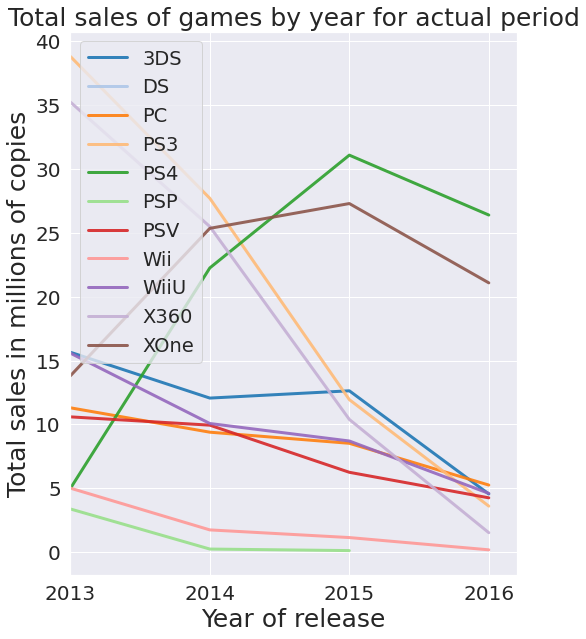

In [57]:
palette = iter(plt.get_cmap('tab20').colors)

for column in actual_sales.columns:
    plt.plot(actual_sales[column], alpha=0.9, label=column, linewidth=3, color=next(palette))

# добавляем легенду и заголовок
plt.legend(loc='upper left', fontsize='large')
plt.title("Total sales of games by year for actual period", fontdict={'size': 25})

# добавляем подписи к осям и изменяем размер подписей
plt.xlabel('Year of release', fontdict={'size': 25})
plt.ylabel('Total sales in millions of copies', fontdict={'size': 25})
plt.xticks(ticks=np.linspace(2013, 2016, 4), fontsize=20)
plt.yticks(fontsize=20)

# задаем диапазон оси x
plt.xlim([2013, 2016.2])

# задаем размер графика
plt.gcf().set_size_inches(8, 10)
plt.show()

Видно, что после 2013 продажи игр росли только на двух платформах XOne и PS4, а в 2016 году продажи упали для всех платформ. Наиболее перспективными на 2017 год выглядят XOne, PS4, также можно рассматривать PC, 3DS и WiiU.

In [58]:
actual_games_df = games_df.query('year_of_release >= 2013')
actual_games_df.groupby('platform').total_sales.sum().sort_values(ascending=False)[:10]

platform
XOne    87.519997
PS4     84.699997
PS3     82.050003
X360    72.639999
3DS     44.889999
WiiU    38.950001
PC      34.459999
PSV     31.029999
Wii      8.070000
PSP      3.740000
Name: total_sales, dtype: float32

In [59]:
games_df.query('year_of_release >= 2015').groupby('platform').total_sales.sum().sort_values(ascending=False)[:10]

platform
PS4     57.470001
XOne    48.369999
3DS     17.180000
PS3     15.540000
PC      13.770000
WiiU    13.300000
X360    11.910000
PSV     10.500000
Wii      1.320000
PSP      0.120000
Name: total_sales, dtype: float32

## Зависимость продаж от платформы

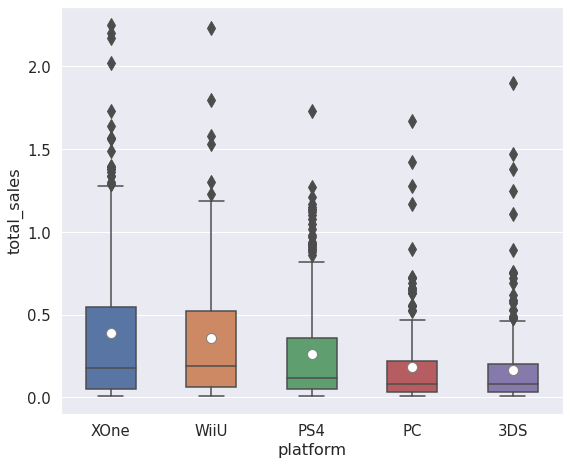

In [60]:
# на основе результатов из предыдущего пункта выбираем наиболее перспективные платформы
top_platforms = ["XOne", "WiiU", "PS4", "PC", "3DS"]

# строим для них ящик с усами по глобальным продажам игр
sns.boxplot(data=actual_games_df.query('platform in @top_platforms'), 
            x='platform', y='total_sales', order=top_platforms, 
            width=0.5, fliersize=10, 
            showmeans=True,  # добавим отображение среднего значения в виде кругляшочка
            meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"grey", 'markersize': 10});

Медианное и среднее значение, а также межквартильный размах распределений больше всего для XOne и WiiU, затем для PS4 и на последнем месте PC вместе с 3DS по данным показателям. Однако для PC чаще всего встречаются выбросы с большими величинами общих продаж.

## Влияние отзывов на продажи для перспективных платформ

In [61]:
# зададим функцию для построения диаграммы рассеяния для пользовательских оценок
def regplot_us(platform_df: pd.DataFrame, platform_name: str):
    sns.regplot(
                data=platform_df, x='total_sales', y='user_score', 
                scatter_kws={'s': 100, 'alpha': 0.7},
                line_kws={'color':'red'}
               )
    
    plt.title(platform_name, fontsize=25)
    plt.xlabel('User score', fontsize=20)
    plt.ylabel('Total sales in millions of copies', fontsize=20)
    
    plt.show()

In [62]:
# то же для оценок критиков
def regplot_cs(platform_df: pd.DataFrame, platform_name: str):
    sns.regplot(
                data=xone_df, x='total_sales', y='critic_score', 
                scatter_kws={'s': 100, 'alpha': 0.7},
                line_kws={'color':'red'}
               )
    
    plt.title(platform_name, fontsize=25)
    plt.xlabel('User score', fontsize=20)
    plt.ylabel('Total sales in millions of copies', fontsize=20)
    
    plt.show()

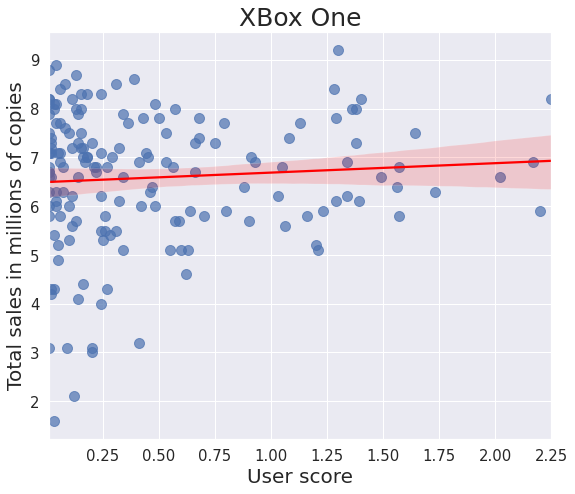

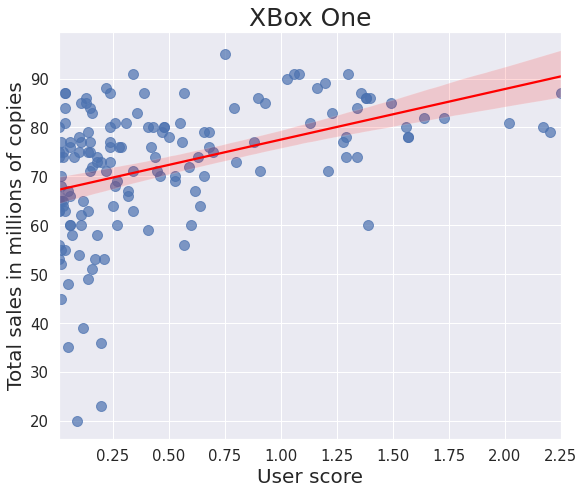

In [63]:
# выберем пока что данные только XBox One
xone_df = actual_games_df.query('platform == "XOne"')

regplot_us(xone_df, 'XBox One')
regplot_cs(xone_df, 'XBox One')

Игры на XOne с оценками ниже 55 от критиков и ниже 4.5 от пользователей практически никогда не продаются тиражом более 250'000 тысяч копий. Играм с оценками "выше среднего" часто удается преодолеть этот барьер. Оценки критиков более смещены в сторону положительных оценок (около 80), в то время как пользовательские оценки в среднем нейтральнее (6-7).

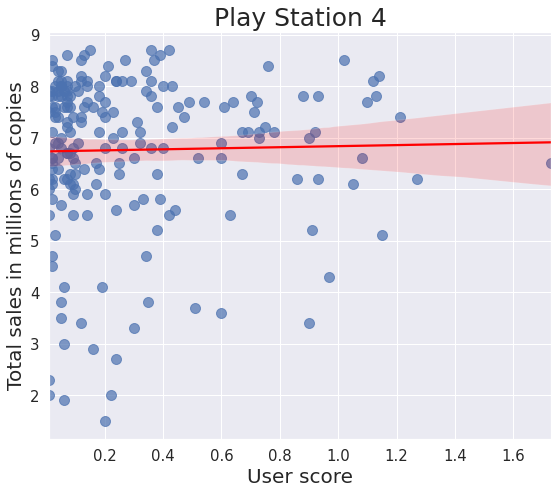

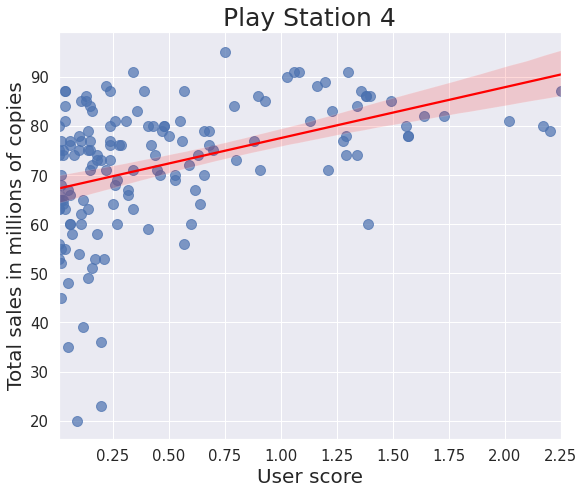

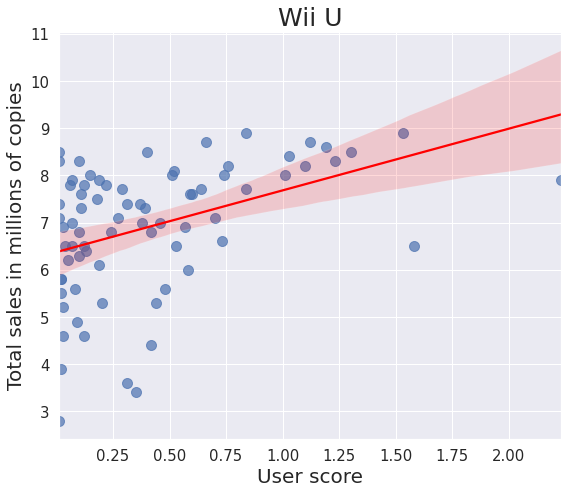

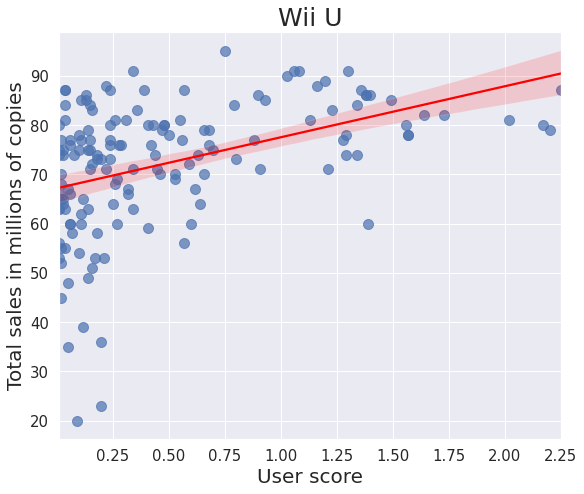

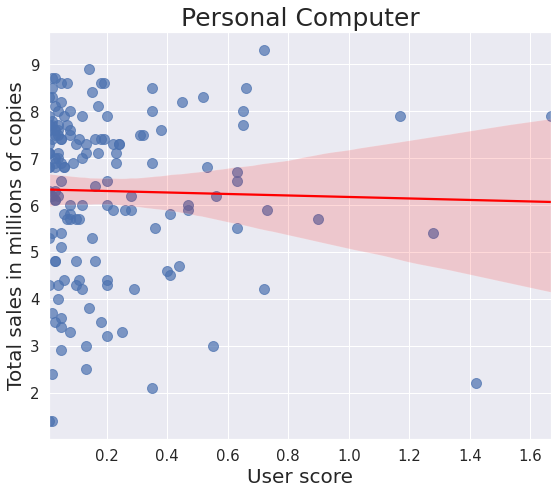

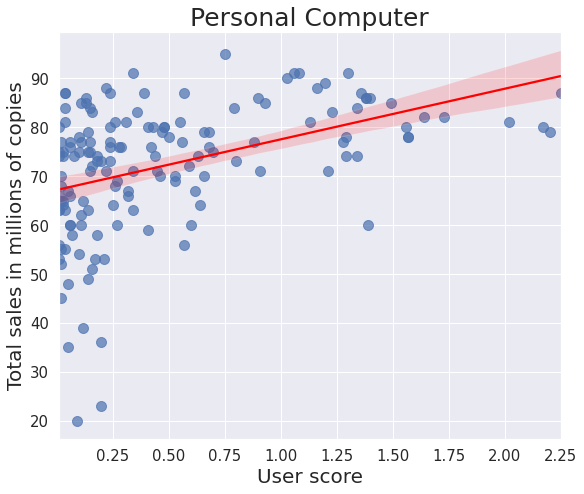

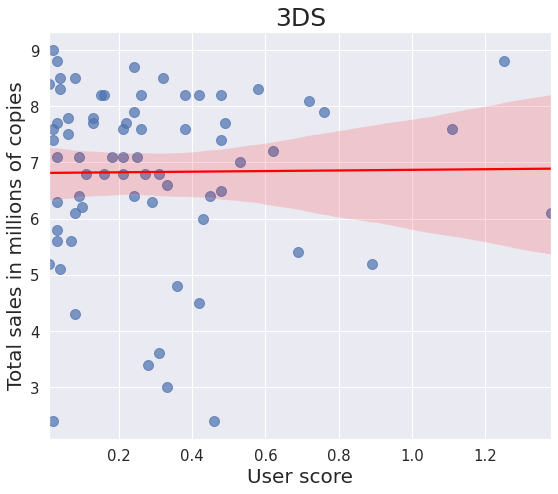

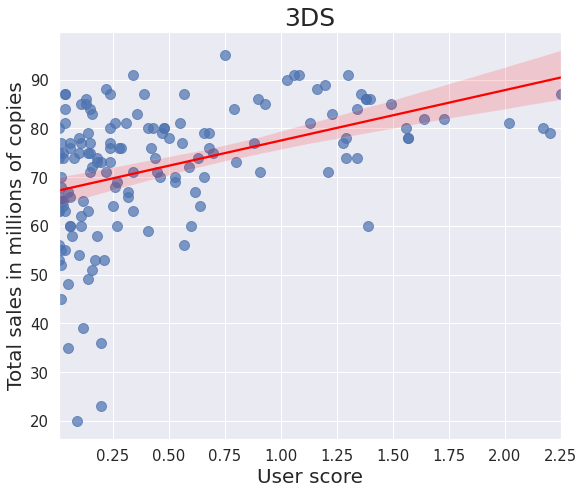

In [64]:
# посмотрим зависимости для остальных перспективных платформ
perspective_platforms = [('PS4', 'Play Station 4'), ('WiiU', 'Wii U'), ('PC', 'Personal Computer'), ('3DS', '3DS')]

for code, name in perspective_platforms:
    platform_df = actual_games_df.query('platform == @code')
    regplot_us(platform_df, name)
    regplot_cs(platform_df, name)

Такие сдвиги оценок критиков и пользователей также характерны для PS4, PC и 3DS, отличия только у WiiU. 

In [65]:
# посмотрим корреляцию для топовых платформ
for platform in top_platforms:
    pl_df = actual_games_df.query('platform == @platform')
    print(f'Корреляция для {platform} продаж и:')
    print(f"оценок пользователей:", round(pl_df.user_score.corr(pl_df.total_sales),2))
    print(f"оценок критиков:", round(pl_df.critic_score.corr(pl_df.total_sales),2), end='\n\n')

Корреляция для XOne продаж и:
оценок пользователей: 0.07
оценок критиков: 0.42

Корреляция для WiiU продаж и:
оценок пользователей: 0.42
оценок критиков: 0.37

Корреляция для PS4 продаж и:
оценок пользователей: 0.02
оценок критиков: 0.27

Корреляция для PC продаж и:
оценок пользователей: -0.02
оценок критиков: 0.29

Корреляция для 3DS продаж и:
оценок пользователей: 0.01
оценок критиков: 0.2



Для большинства платформ коэффициент корреляции Пирсона близок к нулю для оценок пользователей и показывает среднюю связь для оценок критиков. В случае WiiU корреляция имеется также и для оценок пользователей.

## Продажи в зависимости от жанра игры

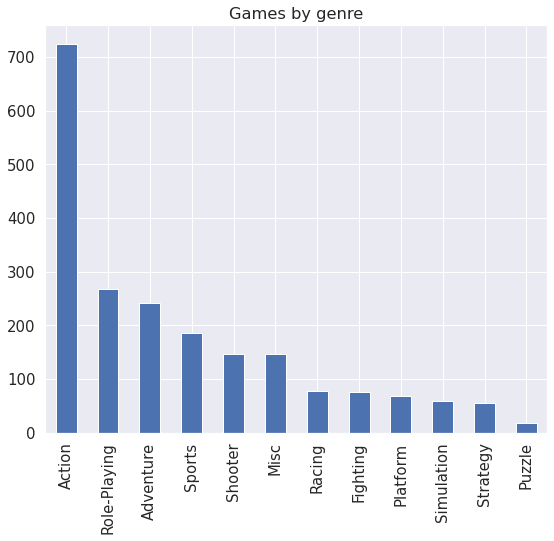

In [66]:
# построим количество выпущенных игр по жанрам
actual_games_df.genre.value_counts().plot(kind='bar', title='Games by genre');

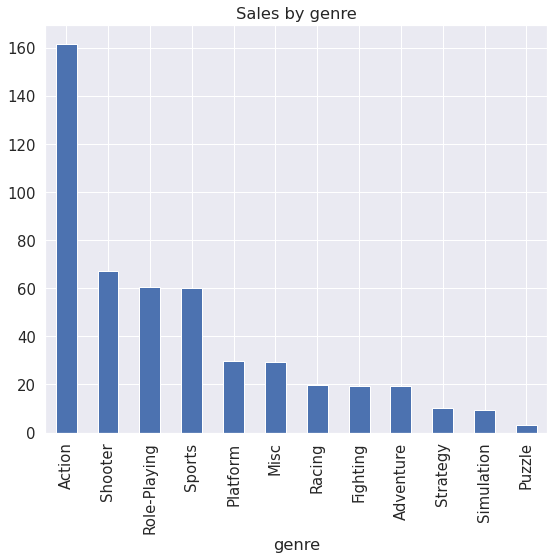

In [67]:
# построим общие продажи для каждого жанра
sales_by_genre = actual_games_df.groupby('genre').total_sales.sum()
sales_by_genre.sort_values(inplace=True, ascending=False)
sales_by_genre.plot(kind='bar', title='Sales by genre');

Больше всего выпущено игр в жанре "Action", меньше всего в "Puzzle". Такая же ситуация и для показателя общих продаж по жанрам. Посмотрим средние значения для общих продаж и оценок от пользователей и критиков по каждому жанру.

In [68]:
# выбираем цветовую палитру
cm = sns.light_palette("orange", as_cmap=True)

# строим сводную таблицу по жанрам
actual_games_df.pivot_table(index='genre', 
                     values=['total_sales', 'user_score', 'critic_score'], 
                     aggfunc='mean').style.background_gradient(cmap=cm)  # раскрашиваем ячейки

,critic_score,total_sales,user_score
genre,,,
Action,70.130745,0.223163,6.790756
Adventure,72.590912,0.080207,7.436842
Fighting,69.224998,0.256974,6.995652
Misc,73.878052,0.202466,6.979167
Platform,72.872337,0.432174,6.588889
Puzzle,75.571426,0.186471,7.471428
Racing,70.490906,0.251026,5.979661
Role-Playing,72.616669,0.226704,7.364341
Shooter,70.689323,0.456395,6.451639


Несмотря на то, что больше всего продаж и выпущенных игр в жанре "Action", средние продажи в нем не самые высокие. В среднем больше всего продается игр в жанрах "Shooter" и "Platform", а самые высокие средние оценки в жанрах "Puzzle" и "Role-Playing".   

# Портрет пользователя каждого региона

## Северная Америка

### За всё время

In [69]:
# поскольку необходимо будет построить по три одинаковых графика для каждого региона, создадим общую функцию, которая
# выводит топ-5 самых популярных платформ и самых популярных жанров за всё время исходя из числа проданных копий игр для них
# а также выводит величину продаж в зависимости от рейтинга ESRB

def plots_for_all_time(df: pd.DataFrame, col_sales: str):
    
    for type_ in ['platform', 'genre', 'rating']:

        sub_df = df.groupby(type_, observed=True)[col_sales].sum().sort_values(ascending=False).iloc[:5]
        sub_df.plot(kind='bar', title=f'Sales by {type_}')
        
        plt.gcf().set_size_inches(6, 6)
        plt.xlabel(None)
        plt.ylabel('Sales in millions of copies')
        plt.show();

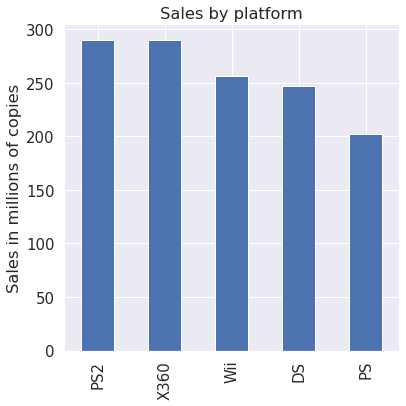

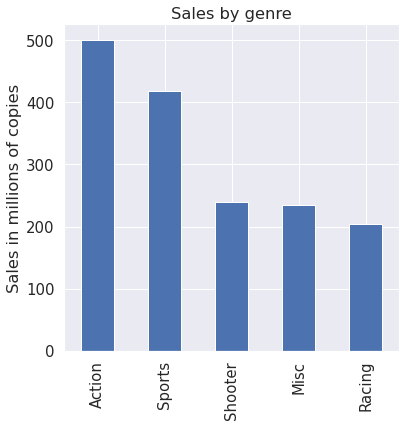

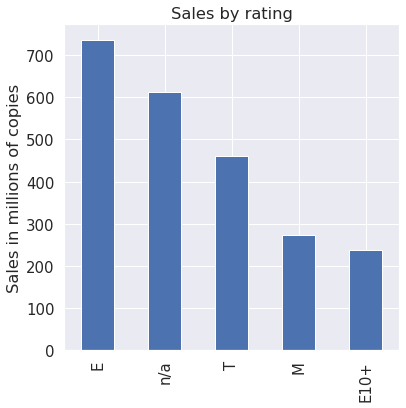

In [70]:
plots_for_all_time(games_df, 'na_sales')

### За актуальный период

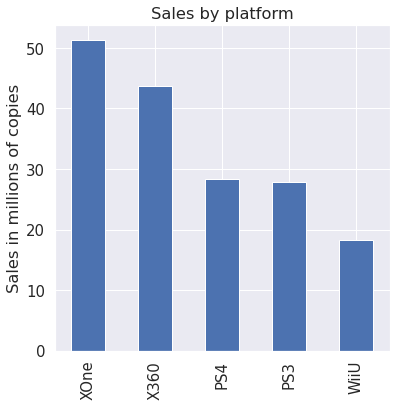

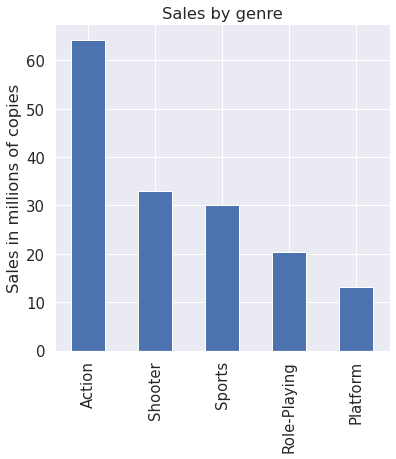

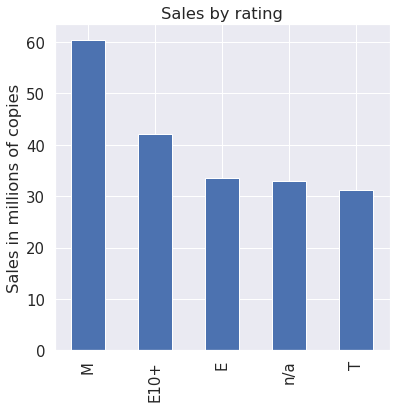

In [71]:
# посчитаем те же топы только для актуального периода с 2013 года
plots_for_all_time(actual_games_df, 'na_sales')

### Промежуточный вывод

Если рассматривать всё время наблюдений, то в Северной Америке наиболее популярны:
- платформы X360, PS2, Wii, DS, PS
- жанры Action, Sports, Shooter, Misc и Racing;
- больше всего продано игр с рейтингом 'E' - для всех.

За актуальный период наблюдается изменение предпочтений. Наиболее популярны:
- платформы XOne, X360, PS4, PS3, WiiU;
- жанры Action, Shooter, Sports, Role-Playing, Misc
- больше всего продано игр со взрослым рейтингом.

Видно, что больше всего выпускается игр для "актуальных" игровых платформ, другими словами - современных. Возрос интерес к шутерам и ролевым играм. Со временем выпускается больше игр со взрослым рейтингом.

## Европа

### За всё время

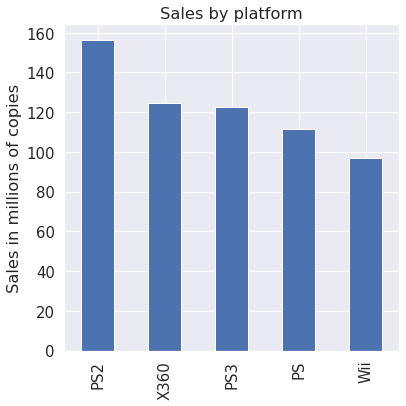

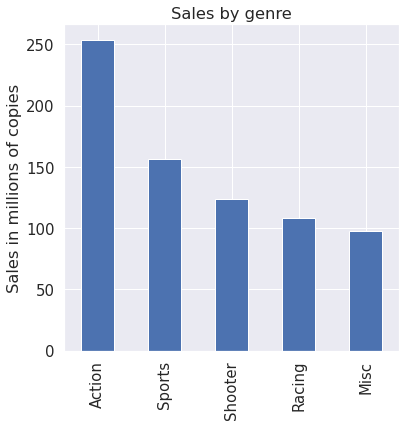

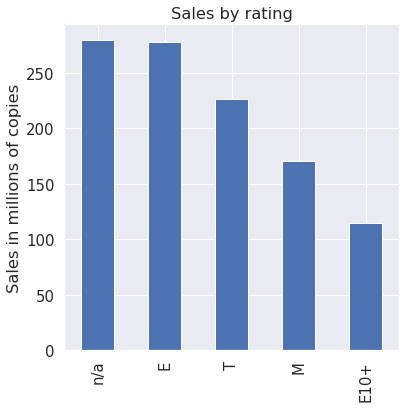

In [72]:
plots_for_all_time(games_df, 'eu_sales')

### За актуальный период

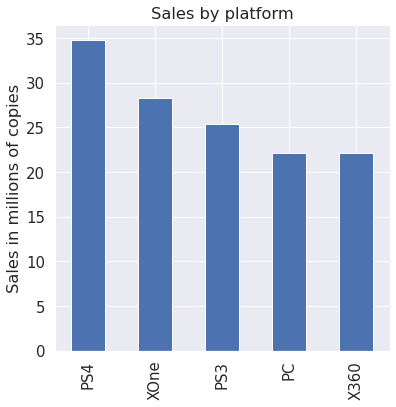

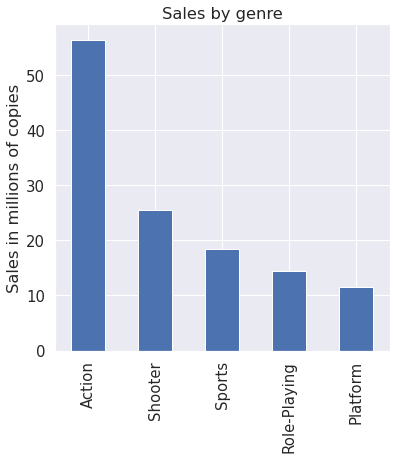

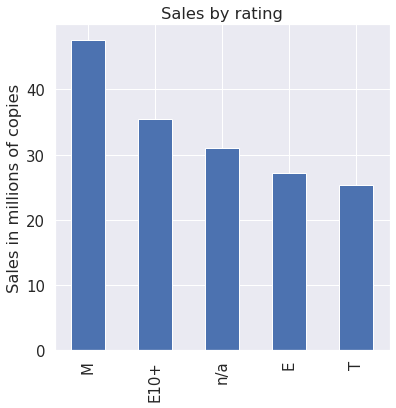

In [73]:
plots_for_all_time(actual_games_df, 'eu_sales')

### Промежуточный вывод

В Европе за всё время наблюдений наиболее популярны:

- платформы PS2, X360, PS, PS3, Wii
- жанры Action, Sports, Shooter, Misc и Racing;
- среди оценных ESRB игр, больше всего продано игр с рейтингом 'E' - для всех.

За актуальный период наиболее популярны:
- платформы PS4, XOne, PC, X360, PS3;
- жанры Action, Shooter, Sports, Role-Playing, Platform; 
- больше всего продано игр со взрослым рейтингом.


## Япония

### За всё время

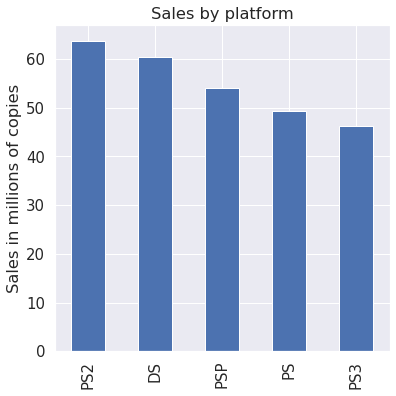

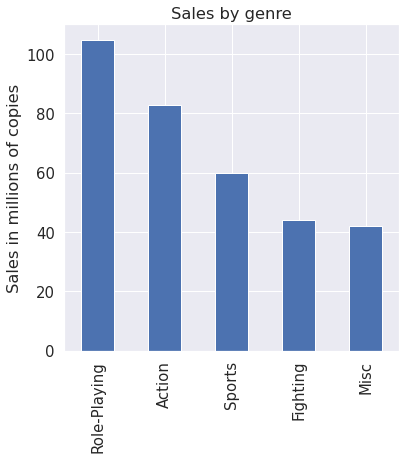

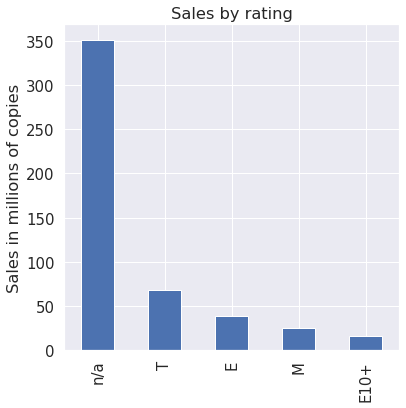

In [74]:
plots_for_all_time(games_df, 'jp_sales')

### За актуальный период

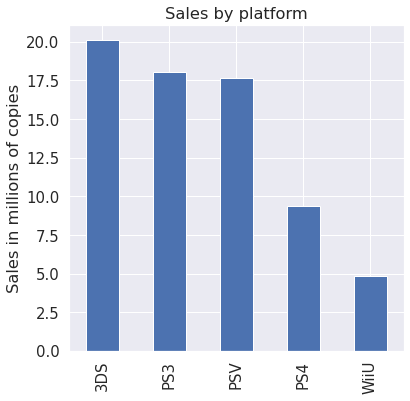

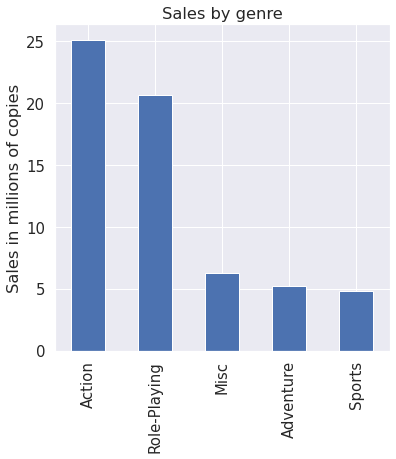

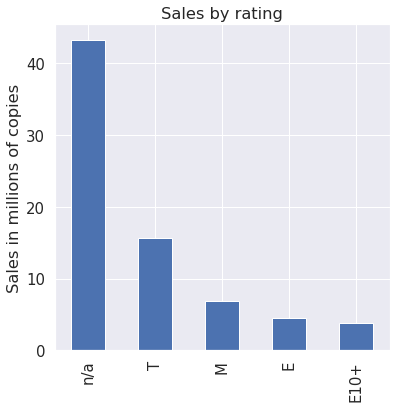

In [75]:
plots_for_all_time(actual_games_df, 'jp_sales')

### Промежуточный вывод

В Японии за всё время наблюдений наиболее популярны:

- платформы PS2, DS, PSP, PS, PS3
- жанры Role-Playing, Action, Sports, Fighting, Misc;
- среди оценных ESRB игр, больше всего продано игр с рейтингом 'T' - для подростков.

За актуальный период наиболее популярны:

- платформы 3DS, PSV, PS3, PS4, WiiU;
- жанры Action, Role-Playing, Misc, Adventure, Sports;
- рейтинг, для которого продано больше всего игр, остался прежним - 'T'.

## Сравнение результатов для разных регионов

Будем рассматривать только актуальный период.

In [76]:
# построим общую таблицу для топ-5 платформ и жанров для каждого региона, для этого
# возьмем данные за актуальный период
regions_dfs = []
genres_dfs = []

# для каждого региона построим отдельную сводную таблицу и добавим в соответствующий список
for region in ['na_sales', 'eu_sales', 'jp_sales']:
    regions_dfs.append(actual_games_df.pivot_table(index='platform', values=region, 
                              aggfunc='sum').sort_values(region, ascending=False).iloc[:5].reset_index().platform)
    regions_dfs[-1].rename(region.split('_')[0].upper(), inplace=True)
    genres_dfs.append(actual_games_df.pivot_table(index='genre', values=region, 
                              aggfunc='sum').sort_values(region, ascending=False).iloc[:5].reset_index().genre)
    genres_dfs[-1].rename(region.split('_')[0].upper(), inplace=True)


In [77]:
# создадим единый датафрейм для платформ
top_platforms = pd.concat((regions_dfs), join='inner', axis=1)
top_platforms.index += 1

# и для жанров
top_genres = pd.concat((genres_dfs), join='inner', axis=1)
top_genres.index += 1

# отобразим таблицы, индексы - место в топе
display(top_platforms)
display(top_genres)

,NA,EU,JP
1,XOne,PS4,3DS
2,X360,XOne,PS3
3,PS4,PS3,PSV
4,PS3,PC,PS4
5,WiiU,X360,WiiU


,NA,EU,JP
1,Action,Action,Action
2,Shooter,Shooter,Role-Playing
3,Sports,Sports,Misc
4,Role-Playing,Role-Playing,Adventure
5,Platform,Platform,Sports


Из представленных таблиц видно, что северо-американский пользователь проедпочитает использовать XBox для игр, в отличие от европейского, для которого на первом месте стоит PS4. Но при этом в обоих регионах используют как XBox так и Play Station. В Японии предпочтение отдается портативным устройствам, таким как 3DS и PSV. В топ-5 у японцев также находится продукция PS, однако XBox сюда не входит. Интересно, что персональные компьютеры для игр популярны только у европейцев, занимают третье место.

Жанровые предпочтения у пользователей из Северной Америки и Европы очень схожи. У японцев с ними меньше общего, однако во всех трех регионах первое место занимает жанр Action.

В Японии в основном продаются игры с подростковым рейтингом, в то время как в Европе и Северной Америке - игры со взрослым рейтингом.

# Проверка гипотез

## Средние пользовательские оценки платформ XBox One и PC

Сформулируем нулевую и альтернативную гипотезы.

$H_0: M_{XOne}=M_{PC}$,  (нулевая) средние значения пользовательских оценок для XBox One и PC равны<br>
$H_1: M_{XOne}\neq M_{PC}$, (альтернативная) средние значения пользовательских оценок для XBox One и PC не равны

In [78]:
# запишем данные с пользовательскими оценками для рассматриваемых платформ в отдельные переменные
xone_us = actual_games_df[(games_df.user_score.notna()) & (games_df.platform == 'XOne')].user_score
pc_us = actual_games_df[(games_df.user_score.notna()) & (games_df.platform == 'PC')].user_score

In [79]:
# зададим порог alpha
alpha = 0.01

# проведем t-тест
result = ttest_ind(pc_us, xone_us)

# выведем результат
if result.pvalue < alpha:
    print(f'Получен статистически значимый результат {result.pvalue:.5f}, отвергаем нулевую гипотезу')
else:
    print(f'Нулевая гипотеза не может быть отвергнута, поскольку полученное p-значение {result.pvalue:.5f} больше порогового')

Нулевая гипотеза не может быть отвергнута, поскольку полученное p-значение 0.09974 больше порогового


Средние значения пользовательских оценок для XBox One и PC близки

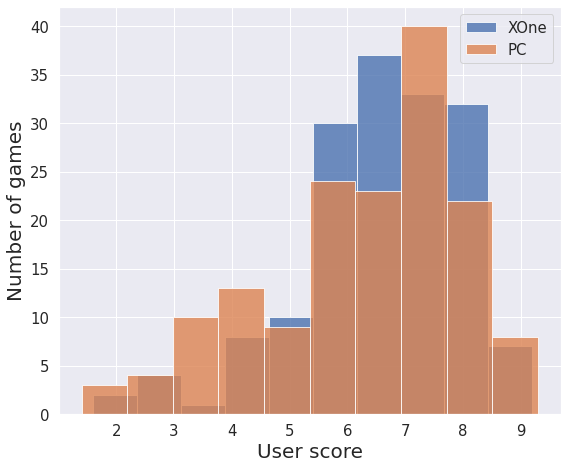

In [80]:
# Выведем заодно распределения
xone_us.hist(alpha=0.8)
pc_us.hist(alpha=0.8)

plt.legend(["XOne", "PC"])
plt.xlabel('User score', fontsize=20)
plt.ylabel('Number of games', fontsize=20);

## Средние пользовательские рейтинги жанров Action и Sports

Сформулируем нулевую и альтернативную гипотезы.

$H_0: M_{Action}=M_{Sports}$,  (нулевая) средние значения пользовательских оценок для жанров Action и Sports равны<br>
$H_1: M_{Action}\neq M_{Sports}$, (альтернативная) средние значения пользовательских оценок для жанров Action и Sports не равны

In [81]:
# запишем данные с пользовательскими оценками для рассматриваемых жанров в отдельные переменные
action_us = actual_games_df[(games_df.user_score.notna()) & (games_df.genre == 'Action')].user_score
sports_us = actual_games_df[(games_df.user_score.notna()) & (games_df.genre == 'Sports')].user_score

In [82]:
# зададим порог alpha
alpha = 0.01

# проведем t-тест
result = ttest_ind(action_us, sports_us)

# выведем результат
if result.pvalue < alpha:
    print(f'Получен статистически значимый результат {result.pvalue:.5f}, отвергаем нулевую гипотезу')
else:
    print(f'Нулевая гипотеза не может быть отвергнута, поскольку полученное p-значение {result.pvalue:.5f} больше порогового')

Получен статистически значимый результат 0.00000, отвергаем нулевую гипотезу


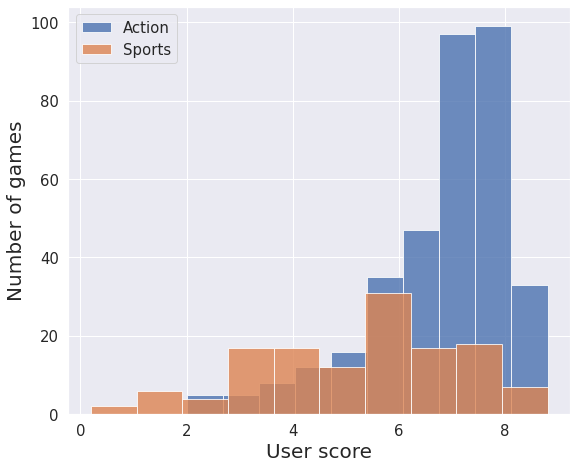

In [83]:
# Выведем заодно распределения
action_us.hist(alpha=0.8)
sports_us.hist(alpha=0.8)

plt.legend(["Action", "Sports"])
plt.xlabel('User score', fontsize=20)
plt.ylabel('Number of games', fontsize=20);

Значения средних пользовательских рейтингов для жанров Action и Sports не равны.

# Общий вывод

- ***На первом этапе*** выполнения работы мы загрузили данные из файла, просмотрели их структуру, построили распределния значений для числовых колонок и определили основые проблемы, встречающиеся в датасете.


- ***На втором этапе*** мы привели в порядок наш датасет: привели названия колонок к питоновскому стилю, заполнили пропуски (там, где это было возможно), удалили записи с большими выбросами в данных, реструктуризировали категории оценок от ESRB.


- ***На третьем этапе*** мы провели исследовательский анализ данных. Можно выделить следующие основные выводы:
    - С 1994 года начался быстрый рост количества выпускаемых в год игр, пик был достигнут в 2009 году, после чего начался спад. С 2012 года количество выпускаемых в год игр изменяется незначительно.
    - В большинстве случаев для игровых платформ наблюдается следующая тенденция: после выхода платформы происходит резкий рост продаж игр для нее. За пару лет до выхода платформы нового поколения наблюдается такой же резкий спад продаж. "Период жизни" платформы составляет примерно 9 лет. Последний (актуальный) период относительно 2016 года начался в 2013 году, с выходом XBox One и Play Station 4.
    - С 2013 года продажи игр росли только на двух платформах (XBox One и PS4), а в 2016 году продажи упали для всех платформ. Наиболее перспективными на 2017 год выглядят XBox One и PS4. DS3, Wii U и PC также могут быть взяты для рассмотрения.
    - Из рассматриваемых платформ наибольшим средним суммарным числом продаж обладает XBox One и Wii U, затем идет PS4, а PC и 3DS обладают самыми маленькими значениями.
    - Игры на XBox One с оценками ниже 55 от критиков и ниже 4.5 от пользователей практически никогда не продаются тиражом более 250'000 тысяч копий. Играм с оценками "выше среднего" часто удается преодолеть этот барьер. Оценки критиков более смещены в сторону положительных оценок (около 80), в то время как пользовательские оценки в среднем нейтральнее (6-7). Сдвиги оценок критиков и пользователей также характерны для остальных платформ.
    - Для большинства платформ коэффициент корреляции Пирсона близок к нулю для оценок пользователей и показывает среднюю связь для оценок критиков. В случае WiiU средняя корреляция имеется также и для оценок пользователей.
    - За актуальный период больше всего выпущено игр в жанре "Action", меньше всего в "Puzzle". Такая же ситуация и для показателя общих продаж по жанрам. Несмотря на это, средний показатель продаж копий на одну игру в жанре "Action" не самый высокий. В среднем больше всего продается копий игр (в пересчете на одну игру) в жанрах "Shooter" и "Platform", а самые высокие средние оценки в жанрах "Pazzle" и "Role-Playing"


- ***На четвертом этапе*** мы определили основные предпочтения в игровых платформах и жанрах для пользователей из Свереной Америки, Европы и Японии. Мы опеределили, что:
    - северо-американский пользователь проедпочитает использовать XBox для игр, в отличие от европейского, для которого на первом месте стоит PS4. Но при этом в обоих регионах используют как XBox так и Play Station. В Японии предпочтение отдается портативным устройствам, таким как 3DS и PSV. В топ-5 у японцев также находится продукция PS, однако XBox сюда не входит. Интересно, что персональные компьютеры для игр популярны только у европейцев, занимают третье место.
    - Жанровые предпочтения у пользователей из Северной Америки и Европы очень схожи. У японцев с ними меньше общего, однако во всех трех регионах первое место занимает жанр Action.
    - В Японии в основном продаются игры с подростковым рейтингом, в то время как в Европе и Северной Америке - игры со взрослым рейтингом.
    
    
- ***На пятом этапе*** мы проверили две гипотезы о равенстве средних пользовательских оценок для платформ XBox One и PC и жанров Action и Sports. Основные выводы:
    - Средние значения пользовательских оценок для XBox One и PC близки;
    - Значения средних пользовательских оценок для жанров Action и Sports не равны.